In [1]:
import os
import math
import random
from fractions import Fraction
import multiprocessing as mp
import numpy as np
from tqdm import tqdm
from haversine import haversine, Unit
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap

In [2]:
# Astronomy-related constants

TE = 24 * 3600  # One Earth sidereal day in seconds

RE = 6371e3  # Mean radius of Earth in meters

u = 3.986e14  # Standard gravitational parameter (μ = GM) in m^3/s^2

K = RE / pow(u, 1/3) * pow(2 * np.pi, 2/3)  

eps = 25 * np.pi / 180  # Maximum elevation angle for ground access, in radians (25°)


In [3]:
def satellite_period(h):
    """
    Compute the orbital period of a satellite at altitude h.

    Parameters:
        h (float): Satellite altitude above Earth's surface (in meters)

    Returns:
        float: Orbital period (in seconds)
    """
    a = RE + h  # Semi-major axis (Earth radius + altitude)
    T = float(2 * np.pi * pow(a**3 / u, 0.5))  # Kepler's third law
    return T

def approximate_ratio(a, b, precision=1e-3):
    """
    Compute the approximate simplest integer ratio between two values.

    Parameters:
        a (float or int): Numerator value
        b (float or int): Denominator value
        precision (float): Precision threshold (default: 1e-3)

    Returns:
        (int, int): Approximated (numerator, denominator) as integers

    Raises:
        ValueError: If denominator is zero
    """
    if b == 0:
        raise ValueError("Denominator cannot be zero")
    
    ratio = Fraction(a, b).limit_denominator(int(1 / precision))
    return ratio.numerator, ratio.denominator

def coverage_eta(T):
    """
    Compute the half-angle of ground coverage (in radians) for a satellite
    with orbital period T.

    Parameters:
        T (float): Orbital period (in seconds)

    Returns:
        float: Coverage angle (eta) in radians
    """
    eta = math.acos(K * math.cos(eps) / pow(T, 2 / 3)) - eps
    return eta
def is_cover(l_sat,p_sat,l_cell,p_cell,eta):
    double_eta=2*eta
    if (p_sat-double_eta)<-np.pi/2 or (p_sat+double_eta)>np.pi/2 or (l_sat-double_eta)<-np.pi or (l_sat+double_eta)>np.pi: ## 如果纬度范围超界，直接用球面距离判断
        d=haversine((np.degrees(p_sat),np.degrees(l_sat)),(np.degrees(p_cell),np.degrees(l_cell)),unit=Unit.METERS)
        if d <= eta*RE:
            return True
    else:
        if (p_sat-double_eta)<=p_cell<=(p_sat+double_eta) and (l_sat-double_eta)<=l_cell<=(l_sat+double_eta):  # 预筛选
            d=haversine((np.degrees(p_sat),np.degrees(l_sat)),(np.degrees(p_cell),np.degrees(l_cell)),unit=Unit.METERS)
            if d <= eta*RE:
                return True
    return False

def calculate_cell_area():
    """
    Compute the surface area of each ground cell (irregular lat-lon grid).
    Returns:
        S_set (list): List of cell areas in square meters.
    """
    S_set = []
    for idx, demand in enumerate(demand_list):
        p_cell = demand['lat_lon'][0]  # latitude in radians
        h = RE * np.radians(cell_size)             # cell height (north-south) in meters

        # Compute arc lengths on both sides of the cell
        L1 = RE * np.sin(np.pi / 2 - abs(p_cell)) * np.radians(cell_size)
        tmp = abs(p_cell - np.radians(cell_size))
        L2 = RE * np.sin(np.pi / 2 - min(tmp, np.pi / 2)) * np.radians(cell_size)

        # Adjust polar case (e.g., South Pole strip)
        if tmp > np.pi / 2:
            h = RE * abs(p_cell + np.pi / 2)

        # Trapezoidal area approximation
        S = 0.5 * h * (L1 + L2)
        S_set.append(S)
    return S_set

def cal_supply_all_cell(sat_pos):
    """
    Compute the satellite supply (capacity) to all ground cells.

    Args:
        sat_pos (tuple): A satellite position (lat, lon, alt in km)

    Returns:
        list: [r_set, sat_pos], where r_set is the normalized capacity allocated to each cell
    """
    p_sat, l_sat, h = sat_pos  # latitude, longitude, altitude (km)
    r_set = []  # List of per-cell coverage results for this satellite

    for idx, demand in enumerate(demand_list):
        l_cell = demand['lat_lon'][1]
        p_cell = demand['lat_lon'][0]
        T = satellite_period(h * 1e3)          # Convert km to meters
        eta = coverage_eta(T)                  # Coverage angle
        r = is_cover(l_sat, p_sat, l_cell, p_cell, eta)
        
        if r:
            S = S_set[idx]                     # Cell area
            r_set.append([idx, S, demand['density']])
        else:
            r_set.append([idx, 0, 0])          # Not covered

    # Normalize coverage area to supply capacity
    S_sum = np.sum([item[1] for item in r_set])
    r_set = [item[1] / S_sum * user_per_sat if S_sum > 0 else 0 for item in r_set]

    return [r_set, sat_pos]


In [4]:
# Load satellite positions (as of 2025-01-01)
starlink_pos = np.load("data/2025_01_01_starlink.npy", allow_pickle=True)

# Load ground demand data
demand_list = np.load("../../Dataset/Demand/starlink_supply_2025_01_01_99449.npy", allow_pickle=True)

# Convert lat/lon to radians for spherical geometry calculations
for idx in range(len(demand_list)):
    demand_list[idx]['lat_lon'][0] = np.radians(demand_list[idx]['lat_lon'][0])
    demand_list[idx]['lat_lon'][1] = np.radians(demand_list[idx]['lat_lon'][1])

# Set cell resolution and per-satellite user capacity
cell_size = 4               # degrees
user_per_sat = 960          # user capacity per satellite

# Precompute area of each demand cell
S_set = calculate_cell_area()

# Compute coverage from all satellites using multiprocessing
with mp.Pool(processes=100) as pool:
    full_cover = list(tqdm(pool.imap(cal_supply_all_cell, starlink_pos), 
                           total=len(starlink_pos), mininterval=5))
    pool.close()
    pool.join()

# Aggregate total supply from all satellites across each cell
total_supply = []
for item in full_cover:
    if len(total_supply) == 0:
        total_supply = np.array(item[0])
    else:
        total_supply += np.array(item[0])

# Compute supply-to-demand ratio for each non-zero demand cell
supply_demand_ratio = []
for idx, demand in enumerate(demand_list):
    if demand['density'] != 0:
        ratio = total_supply[idx] / demand['density']
        supply_demand_ratio.append(ratio)

# Output the average supply/demand ratio
print(np.mean(supply_demand_ratio))

# Save the result
# np.save("data/supply_demand_ratio_official_starlink.npy", supply_demand_ratio)

100%|██████████| 6793/6793 [00:09<00:00, 718.10it/s]


1522.0362757975377


In [5]:
# supply_demand_ratio=np.load("data/supply_demand_ratio_official_starlink.npy",allow_pickle=True)

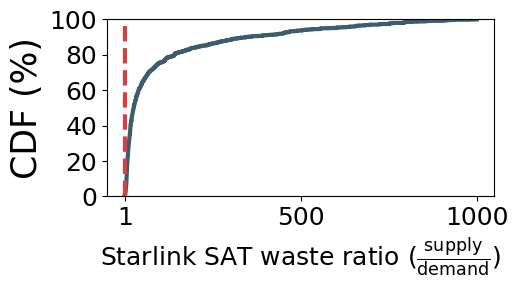

In [ ]:
# Plot CDF of supply-to-demand ratio (i.e., Starlink satellite "waste ratio")

fig = plt.figure(figsize=(5, 2.3))

colors = ['#3E5C70', '#F9AE78', '#E47158']  # Custom color palette

# Compute histogram and CDF
count, bins_count = np.histogram(supply_demand_ratio, bins=np.arange(0, 1000, 0.1))
pdf = count / sum(count)           # Probability density function
cdf = np.cumsum(pdf)               # Cumulative distribution function

# Plot the CDF curve
plt.plot(bins_count[1:], cdf * 100, label="CDF", lw=3, color=colors[0])

# Set y-axis to percentage scale
plt.ylim(0, 100)

# Set x- and y-axis ticks and labels
plt.xticks([1, 500, 1000], fontsize=18)
plt.yticks(fontsize=18)

# Vertical dashed line at x=0 for reference
plt.vlines(0, 0, 110, "#D84040", ls="--", lw=3)

# Axis labels
plt.ylabel("CDF (%)", fontsize=25)
plt.xlabel("Starlink SAT waste ratio " + r"($\frac{\mathrm{supply}}{\mathrm{demand}}$)", fontsize=18)

# Save the figure
plt.savefig("figure4_left.pdf", bbox_inches="tight")
plt.savefig("figure4_left.png", bbox_inches="tight")

# Figure 4b

In [20]:
import numpy as np
import pandas as pd
import os
import json
import math
from datetime import datetime,timedelta
from tqdm import tqdm
from skyfield.api import load, EarthSatellite,wgs84
from skyfield.elementslib import osculating_elements_of
from skyfield.api import utc
from fractions import Fraction
import matplotlib.pyplot as plt

In [21]:
sat_height=540
T=satellite_period(sat_height*1e3)
p,q=approximate_ratio(int(T), TE,precision=1e-3)
eta=coverage_eta(T)

In [22]:
tle=['1 53179U 22083AZ  24366.46547442  .00000088  00000-0  23630-4 0  9991', '2 53179  53.2189 268.5393 0002174  82.5216 277.6023 15.08841050136514']

In [23]:
def split_time(startT,endT,ttype,step):
    #按照step的粒度切割时间
    time_set=[]
    pac=startT
    while pac<=endT:
        #pac = pac.replace(tzinfo=utc) 
        time_set.append(pac)
        if ttype=="mins":
            pac+=timedelta(minutes=step)
        elif ttype=="days":
            pac+=timedelta(days=step)
    #print(len(time_set))
    return time_set
time_set=split_time(datetime(2025,1,1),datetime(2025,1,2),"mins",1)

In [24]:
ts = load.timescale()
target_t=[]
for epoch in time_set:
    epoch_zone=epoch.replace(tzinfo=utc)
    t = ts.from_datetime(epoch_zone)
    target_t.append(t)
print(len(target_t))

1441


In [25]:
sat_pos=[]
tle1=tle[0]
tle2=tle[1]
satellite = EarthSatellite(tle1,tle2, 'ISS (ZARYA)', ts)
for t in tqdm(target_t):
    geocentric = satellite.at(t)
    lat, lon = wgs84.latlon_of(geocentric)
    height=wgs84.height_of(geocentric).km
    sat_pos.append([lon.radians,lat.radians])

100%|██████████| 1441/1441 [00:00<00:00, 2641.95it/s]


In [26]:
total_supply_starlink=[]
for idx,demand in enumerate(demand_list):
    if demand['density']!=0:
        total_supply_starlink.append(total_supply[idx]/demand['density'])
    else:
        total_supply_starlink.append(0)

In [27]:
distribution=np.load("./data/starlink_user_distrubution.npy",allow_pickle=True).item()
print(len(distribution))
demand_list=[]
for (lat, lon), value in distribution.items():
    # lats.append(lat-2)
    # lons.append(lon+2)
    # values.append(value)
    demand_list.append({'lat_lon':[lat-2,lon+2],'density':value})

4050


In [28]:
util_single=[]
for pos in tqdm(sat_pos):
    l_sat,p_sat=pos
    r_set=[]
    for idx,demand in enumerate(demand_list):
        l_cell=np.radians(demand['lat_lon'][1])
        p_cell=np.radians(demand['lat_lon'][0])
        r=is_cover(l_sat,p_sat,l_cell,p_cell,eta) #用经纬度判断
        if r:
            S=S_set[idx]
            r_set.append([idx,S,demand['density']])
    if len(r_set)!=0:
        S_sum=np.sum([item[1] for item in r_set])
        factor=user_per_sat/S_sum
        r_set_sum=0
        for item in r_set:
            cid=item[0]
            if total_supply_starlink[cid]!=0:
                r_set_sum+=min(item[1]*factor,item[2]/total_supply_starlink[cid])
        util_single.append(r_set_sum/user_per_sat)

100%|██████████| 1441/1441 [00:18<00:00, 76.16it/s]


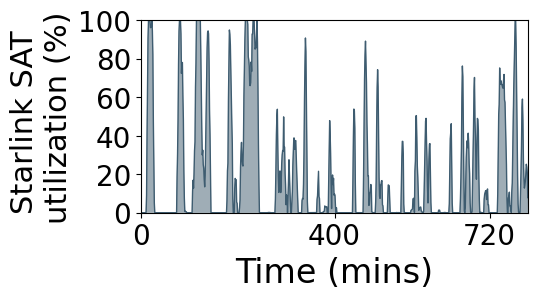

In [30]:
fig=plt.figure(figsize=(5,2.5))
colors=['#3E5C70','#F9AE78','#E47158']
plt.stackplot(list(range(1441)),[item*100 for item in util_single],lw=0.5,color="#9FADB6")
plt.plot([item*100 for item in util_single],color=colors[0],lw=1)
plt.xlim(0,800)
plt.ylim(0,100)
plt.xticks([0,400,720],fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Starlink SAT \nutilization (%)",fontsize=22)
plt.xlabel("Time (mins)",fontsize=24)
plt.savefig("figure4_right.pdf",bbox_inches="tight")
plt.savefig("figure4_right.png",bbox_inches="tight")